# League of Legends Project - Elo System

- The purpose of this notebook is to create an elo system for predicting games.
- Rather than simply using the categorical data of the team, player, and champion names, as a feature in a machine learning model, an elo system works chronologically and so doesn't use the results of games that hasn't happened yet to find the impact of a team on the result of the game.
- I will use the teams, the players and the champions in this elo system, each with their own rating.
- The results of the elo system can then be used as a feature in the machine learning models in the LoL_Predictions notebook.

### What is an elo system?

In an elo system, each team has a rating, when 2 teams play each other, the winning team's rating increases and the losing team's decreases.
The size of this increase is determined by the difference in the ratings between the 2 teams.

If the winning team has a rating of 1,600 and the losing team 1,400, the rating change will be smaller than if the winning team had the rating of 1,400 and the losing team a rating of 1,600.  The higher the rating, the better the team is, and so an upset, of a worse team beating

In short, the larger the value of:<br>
losing team rating - winning team rating<br>
the larger the change in rating.

The winning team's rating change is the exact opposite of the losing team's rating change.

Each team's rating is therefore changed after every game they play and until it converges on an "optimal" or "true" rating.

My elo system will calculate the overall team rating as a composite of each player's rating, the team/organisation rating and a rating for each champion selected.

An explanation of the formula to calculate the elo system is located where the formula is, in this notebook.

# Step 1: Clean the Data

In [1]:
import numpy as np
import pandas as pd
from functools import reduce
from scipy.optimize import minimize
import matplotlib.pyplot as plt

With convention, I will use a mean elo rating of 1,500 and an elo_width of 400.  This is purely for aesthetic reasons because other publically available elo systems use these metrics.

In [2]:
mean_elo = 1500
elo_width = 400

Reading in the dataframe that was pickled in the LoL_Data_Exploration Notebook

In [3]:
dflol = pd.read_pickle("dflol.pkl")

In [6]:
dflol.head()

,datacompleteness,url,league,year,split,playoffs,date,game,patch,participantid,...,opp_csat25,golddiffat25,xpdiffat25,csdiffat25,killsat25,assistsat25,deathsat25,opp_killsat25,opp_assistsat25,opp_deathsat25
gameid,,,,,,,,,,,,,,,,,,,,,
TRLH3/33,complete,http://matchhistory.na.leagueoflegends.com/en/...,EU LCS,2014,Spring,0,2014-01-14 17:52:02,1.0,3.15,1,...,206.0,76.0,-512.0,-18.0,3.0,4.0,0.0,1.0,2.0,2.0
TRLH3/33,complete,http://matchhistory.na.leagueoflegends.com/en/...,EU LCS,2014,Spring,0,2014-01-14 17:52:02,1.0,3.15,2,...,140.0,-888.0,351.0,-42.0,0.0,5.0,3.0,2.0,1.0,1.0
TRLH3/33,complete,http://matchhistory.na.leagueoflegends.com/en/...,EU LCS,2014,Spring,0,2014-01-14 17:52:02,1.0,3.15,3,...,225.0,621.0,733.0,8.0,1.0,5.0,1.0,1.0,2.0,0.0
TRLH3/33,complete,http://matchhistory.na.leagueoflegends.com/en/...,EU LCS,2014,Spring,0,2014-01-14 17:52:02,1.0,3.15,4,...,161.0,3265.0,1950.0,50.0,6.0,2.0,0.0,0.0,0.0,4.0
TRLH3/33,complete,http://matchhistory.na.leagueoflegends.com/en/...,EU LCS,2014,Spring,0,2014-01-14 17:52:02,1.0,3.15,5,...,28.0,1780.0,2397.0,-19.0,0.0,7.0,0.0,0.0,1.0,3.0


Confirming that the dataset is already in chronological order

In [4]:
dftime = dflol.loc[dflol["participantid"] == 200, ["date", "year"]] # Only selecting 1 row (out of 12) per game
len(dftime["date"][dftime["date"] < dftime["date"].shift()]) # Checking how many games happened before the game above them in the dataset

0

Dropping columns that are not needed for the elo system

In [8]:
dflol = dflol.drop(
    labels=["teamname", "playername", "datacompleteness", "url", "league", "split", "playoffs", "date",
            "game", "patch", "ban1", "ban2", "ban3", "ban4", "ban5", "pick1", "pick2", "pick3", "pick4", "pick5",
            "gamelength", "teamkills", "teamdeaths", "chemtechs", "hextechs", "dragons (type unknown)", "void_grubs",
            "opp_void_grubs", "turretplates", "opp_turretplates", "elementaldrakes", "opp_elementaldrakes",
            "monsterkillsownjungle", "monsterkillsenemyjungle", "participantid", "firstdragon", "dragons",
            "opp_dragons", "infernals", "mountains", "clouds", "oceans", "elders", "opp_elders", "firstherald",
            "heralds", "opp_heralds", "firstbaron", "barons", "opp_barons", "firsttower", "towers", "opp_towers",
            "firstmidtower", "firsttothreetowers", "gspd", "gpr", "team kpm", "ckpm", "kills", "deaths", "assists",
            "doublekills", "triplekills", "quadrakills", "pentakills", "firstblood", "firstbloodkill",
            "firstbloodassist", "firstbloodvictim", "inhibitors", "opp_inhibitors", "damagetochampions", "dpm",
            "damageshare", "damagetakenperminute", "damagemitigatedperminute", "wardsplaced", "wpm", "wardskilled",
            "wcpm", "controlwardsbought", "visionscore", "vspm", "totalgold", "earnedgold", "earned gpm",
            "earnedgoldshare", "goldspent", "total cs", "minionkills", "monsterkills", "cspm", 'goldat10', 'xpat10',
            'csat10', 'opp_goldat10', 'opp_xpat10', 'opp_csat10', 'golddiffat10', 'xpdiffat10', 'csdiffat10',
            'killsat10', 'assistsat10', 'deathsat10', 'opp_killsat10', 'opp_assistsat10', 'opp_deathsat10', 'goldat15',
            'xpat15', 'csat15', 'opp_goldat15', 'opp_xpat15', 'opp_csat15', 'golddiffat15', 'xpdiffat15', 'csdiffat15',
            'killsat15', 'assistsat15', 'deathsat15', 'opp_killsat15', 'opp_assistsat15', 'opp_deathsat15', 'goldat20',
            'xpat20', 'csat20', 'opp_goldat20', 'opp_xpat20', 'opp_csat20', 'golddiffat20', 'xpdiffat20', 'csdiffat20',
            'killsat20', 'assistsat20', 'deathsat20', 'opp_killsat20', 'opp_assistsat20', 'opp_deathsat20', 'goldat25',
            'xpat25', 'csat25', 'opp_goldat25', 'opp_xpat25', 'opp_csat25', 'golddiffat25', 'xpdiffat25', 'csdiffat25',
            'killsat25', 'assistsat25', 'deathsat25', 'opp_killsat25', 'opp_assistsat25', 'opp_deathsat25'],
    axis=1)

In [9]:
# Columns selected are the year, gameid, side, position, playerid, teamid, champion, and result.
dflol.head(12)

,year,side,position,playerid,teamid,champion,result
gameid,,,,,,,
TRLH3/33,2014,Blue,top,oe:player:e4e943fa882367a96fb2a365de4e28c,oe:team:78f183fa5a7d8ecb22b9ad272c3abd7,Trundle,1
TRLH3/33,2014,Blue,jng,oe:player:e4cd1e7b68ee6b595a6e4c7cd2c56d8,oe:team:78f183fa5a7d8ecb22b9ad272c3abd7,Vi,1
TRLH3/33,2014,Blue,mid,oe:player:5d69aabb447fa09188638716fe549b6,oe:team:78f183fa5a7d8ecb22b9ad272c3abd7,Orianna,1
TRLH3/33,2014,Blue,bot,oe:player:d8362fe0d38ca0e70953ed957deaa00,oe:team:78f183fa5a7d8ecb22b9ad272c3abd7,Jinx,1
TRLH3/33,2014,Blue,sup,oe:player:5ebcf3b41dc66e5839da4c5f58bd907,oe:team:78f183fa5a7d8ecb22b9ad272c3abd7,Annie,1
TRLH3/33,2014,Red,top,oe:player:c248a757d55f7ba42f3ffa39f716687,oe:team:3e18c32708da93cf6bdbd1d20b76731,Dr. Mundo,0
TRLH3/33,2014,Red,jng,oe:player:1c7db660fc268b1d2747939129d6101,oe:team:3e18c32708da93cf6bdbd1d20b76731,Shyvana,0
TRLH3/33,2014,Red,mid,oe:player:70f2e5e51d358b04a8485db5a382f1a,oe:team:3e18c32708da93cf6bdbd1d20b76731,LeBlanc,0
TRLH3/33,2014,Red,bot,oe:player:0cd6ba51204139f1e54c05c7c07e154,oe:team:3e18c32708da93cf6bdbd1d20b76731,Lucian,0


Combining the playerid and teamid columns together.  This is not strictly necessary, but it reduces the dimensionality of the dataframe.

In [10]:
dflol["playerid"] = dflol["playerid"].fillna(dflol["teamid"])
dflol = dflol.dropna(subset=["playerid"]).drop("teamid", axis=1)

In [18]:
dflol[dflol['position'] != 'team'].isna().sum()

year        0
side        0
position    0
playerid    0
champion    0
result      0
dtype: int64

There are no missing values in the player rows.

In [17]:
dflol[dflol['position'] == 'team'].isna().sum()

year             0
side             0
position         0
playerid         0
champion    163957
result           0
dtype: int64

The only NaN values in the team rows are in the "champion" column, where teams do not select a champion.

In [19]:
dflol.dtypes

year          uint16
side        category
position    category
playerid      object
champion      object
result         uint8
dtype: object

# Step 2: Data Engineering

In [20]:
# Eliminating the NaN value from the "champion" column by replacing them with "Team".  This allows pd.factorize to be used effectively on the column.
dflol["champion"] = dflol["champion"].fillna("Team")

# Changing the "champion" column to inlude the position of the player as well.  This reflects the different roles of different champions when they are expected to fulfill different roles.
dflol["champion"] = (dflol["position"].astype(str) + "_" + dflol["champion"])

In [21]:
# Factorizing "playerid", and "champion".
dflol["playerid"] = pd.factorize(dflol["playerid"])[0]
dflol["champion"] = pd.factorize(dflol["champion"])[0]

print(f"There are {dflol['playerid'].nunique()} unique players and teams")
print(f"There are {dflol['champion'].nunique()} unique champion position combinations")

There are 11506 unique players and teams
There are 756 unique champion position combinations


### Reshaping the DataFrame
I am reshaping the dataframe to ensure that for each game, there is only 1 column.

In [22]:
# Split the data into winners and losers and adding prefixes.  Because the winners and losers now have column prefixes, I can delete the "result" column.
win_df = dflol[dflol["result"] == 1].drop("result", axis=1).add_prefix("win_", axis=1)

# Because the rows will be combined, in order to prevent duplicate columns, I will delete "result", "side", and "year" from lose_df
lose_df = dflol[dflol["result"] == 0].drop(["result", "side", "year"], axis=1).add_prefix("lose_", axis=1)

In [23]:
# Split the winners and losers into each position.

positions_list1 = list(range(6))
positions_list1[0] = win_df[win_df["win_position"] == "top"]
positions_list1[1] = win_df[win_df["win_position"] == "jng"]
positions_list1[2] = win_df[win_df["win_position"] == "mid"]
positions_list1[3] = win_df[win_df["win_position"] == "bot"]
positions_list1[4] = win_df[win_df["win_position"] == "sup"]
positions_list1[5] = win_df[win_df["win_position"] == "team"]

positions_list2 = list(range(6))
positions_list2[0] = lose_df[lose_df["lose_position"] == "top"]
positions_list2[1] = lose_df[lose_df["lose_position"] == "jng"]
positions_list2[2] = lose_df[lose_df["lose_position"] == "mid"]
positions_list2[3] = lose_df[lose_df["lose_position"] == "bot"]
positions_list2[4] = lose_df[lose_df["lose_position"] == "sup"]
positions_list2[5] = lose_df[lose_df["lose_position"] == "team"]

In [24]:
for i in range(len(positions_list1)):

    # Because I am combining the columns of the different positions, and adding prefixes, I can delete the position column.
    positions_list1[i] = positions_list1[i].drop(["win_position"],
                                               axis=1)

    # Only keep 1 "win_side" and "win_year" column.
    if i > 0:
        positions_list1[i] = positions_list1[i].drop(["win_side", "win_year"],
                                                   axis=1)

    # Choosing the correct prefix.
    if i == 0:
        pos = "top_"
    elif i == 1:
        pos = "jng_"
    elif i == 2:
        pos = "mid_"
    elif i == 3:
        pos = "bot_"
    elif i == 4:
        pos = "sup_"
    else:
        pos = "team_"

    # Adding the new prefixes to the columns.
    new_columns1 = []
    for c in positions_list1[i].columns.to_list():
        c = pos + c
        new_columns1.append(c)
    positions_list1[i].columns = new_columns1

In [25]:
for i in range(len(positions_list2)):

    # Because I am combining the columns of the different positions, and adding prefixes, I can delete the position column.
    positions_list2[i] = positions_list2[i].drop(["lose_position"],
                                                 axis=1)

    # Choosing the correct prefix.
    if i == 0:
        pos = "top_"
    elif i == 1:
        pos = "jng_"
    elif i == 2:
        pos = "mid_"
    elif i == 3:
        pos = "bot_"
    elif i == 4:
        pos = "sup_"
    else:
        pos = "team_"

    # Adding the new prefixes to the columns.
    new_columns2 = []
    for c in positions_list2[i].columns.to_list():
        c = pos + c
        new_columns2.append(c)
    positions_list2[i].columns = new_columns2

In [94]:
# Merging the 12 dataframes into 1 dataframe.
elo_win_df = (reduce(lambda x, y: pd.merge(x,y, on="gameid"),positions_list1)
              .rename({"top_win_side":"side", "top_win_year":"year"}, axis=1))

elo_lose_df = reduce(lambda x, y: pd.merge(x,y, on="gameid"), positions_list2)

elo_df = pd.merge(elo_win_df, elo_lose_df, on="gameid")

In [95]:
elo_df.head()

,year,side,top_win_playerid,top_win_champion,jng_win_playerid,jng_win_champion,mid_win_playerid,mid_win_champion,bot_win_playerid,bot_win_champion,...,jng_lose_playerid,jng_lose_champion,mid_lose_playerid,mid_lose_champion,bot_lose_playerid,bot_lose_champion,sup_lose_playerid,sup_lose_champion,team_lose_playerid,team_lose_champion
gameid,,,,,,,,,,,,,,,,,,,,,
TRLH3/33,2014,Blue,0,0,1,1,2,2,3,3,...,6,6,7,7,8,8,9,9,11,10
TRLH3/44,2014,Blue,12,11,13,12,14,13,15,8,...,18,1,19,16,20,17,21,9,23,10
TRLH3/76,2014,Red,0,15,1,1,2,20,3,3,...,18,18,19,16,20,19,21,9,23,10
TRLH3/85,2014,Blue,5,22,6,18,7,23,8,3,...,13,25,14,26,15,8,16,14,22,10
TRLH3/10072,2014,Red,29,15,30,1,31,7,32,27,...,25,18,26,20,27,8,28,21,34,10


Each column corresponds to a single game, with all of the relevant data for that game in just the 1 column (rather than the original 12).

### Preparing the Dataset for the Elo System

In [96]:
# Reorganising the columns of the dataframe to be easier to use with zip()
elo_df = elo_df[["side", "top_win_playerid", "jng_win_playerid", "mid_win_playerid", "bot_win_playerid", "sup_win_playerid", "team_win_playerid",  "top_lose_playerid", "jng_lose_playerid", "mid_lose_playerid", "bot_lose_playerid", "sup_lose_playerid", "team_lose_playerid", "top_win_champion", "jng_win_champion", "mid_win_champion", "bot_win_champion", "sup_win_champion", "top_lose_champion", "jng_lose_champion", "mid_lose_champion", "bot_lose_champion", "sup_lose_champion", "year"]]

In [97]:
# Make the side column into 1s and -1s for the purposes of using it as a home field advantage adjuster.
elo_df["side"] = pd.factorize(elo_df["side"])[0]
elo_df["side"] = ((elo_df["side"] * -2) + 1)
elo_df["side"][:5]

gameid
TRLH3/33       1
TRLH3/44       1
TRLH3/76      -1
TRLH3/85       1
TRLH3/10072   -1
Name: side, dtype: int64

In [98]:
print(f"There are {elo_df.shape[0]} games recorded in elo_df")

There are 81187 games recorded in elo_df


In order to have test dataset that is not trained on games that have not happened yet, I will split the test and train arrays manually, by date, rather than doing so randomly.

In [99]:
train_elo_df = elo_df.iloc[:70000]
test_elo_df = elo_df.iloc[70000:]

# Step 3: Training the Elo System

Elo update formula.  This formula calculates 2 things.

First, it calculates "p" which is the probability that the team that actually won will win.

    p = 1. / (1. + np.power(10, (loser_elo - (winner_elo + hfa)) / 400.))

To do this, it applies the hfa, or home field advantage.  This is a constant that either adds to, or takes away from the winning team's elo rating (only in the calculation) depending on whether the winning team was on Blue side.

    winner_elo + hfa

From the LoL_Data_Exploration notebook, we know that the team on Blue side wins games around 53% of the time, so there is a slight advantage that the elo system will include in its prediction.

After the hfa is accounted for, I find out the difference between the losing team's and winning's team elo.  This is then divided by 400.

    loser_elo - (winner_elo + hfa)) / 400.

This 400, is a fixed constant called the elo_width.  Changing the elo_width does not affect the system's predictions and is primarily an aesthetic feature.  What it technically means is that if a team's rating is 400 larger than the other team, that team's probability of winning is 10x larger than the team with a rating 400 smaller.

This value is then used in 1 / (1+ 10^x) as x.

    1. / (1. + np.power(10, (loser_elo - (winner_elo + hfa)) / 400.))

This is an exponential decay function.  The value of p will never be above 1 or below 0.  It plateaus around 1 and 0 so that very large differences in teams' ratings (larger than 600) don't have significantly larger probabilities than if the gap was just 400.

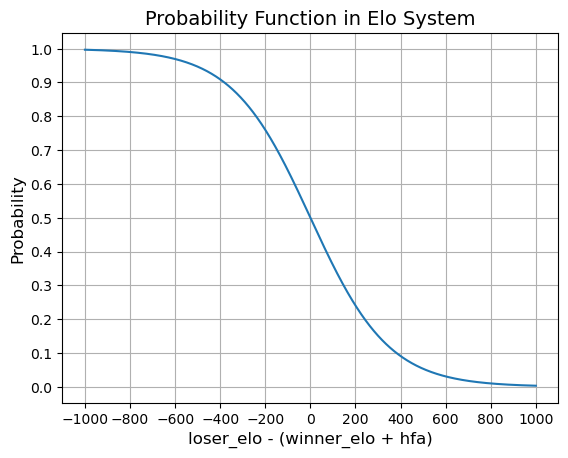

In [46]:
x = np.linspace(-1000,1000,2000)
y = 1. / (1. + np.power(10, x/400))
plt.plot(x, y)

plt.xticks(range(-1000, 1001, 200))
plt.yticks(np.arange(0,1.01,0.1))
plt.grid()

plt.title("Probability Function in Elo System", fontsize=14)
plt.xlabel("loser_elo - (winner_elo + hfa)", fontsize=12)
plt.ylabel("Probability", fontsize=12)

plt.show()

The second part of the update_elo function returns the change in the ratings.

    k * (1. -  p)

 k is a constant that changes depending on the elo system.  A larger k value means that teams' ratings will change more for each match meaning that the system is quick to adjust to changes in a team's relative strength.  A smaller k value means the opposite.  k values are usually between 10 and 100.

I will have to find the optimal value for k, and the optimal value for bsa (Blue Side Advantage), which is used to calculate the hfa.

In [ ]:
def update_elo(winner_elo, loser_elo, k, hfa):

    p = 1. / (1. + np.power(10, (loser_elo - (winner_elo + hfa)) / 400.))

    change = k * (1. - p)

    return (change, p)

### Optimising K and HFA
Within my elo system, there are several other constants to optimise, but first, I will try and find optimal values for k and bsa.

From the LoL_Data_Exploration notebook, I found that the team on Blue side won games 53.2% of the time.

This function is a section of update_elo function and only calculates the probability (p).  I will use it to find a rough value for bsa.

Because I am expecting k and bsa to be well above 1, and the rest of the values I will optimise, to do with adjusting the component ratings before and after games, I am expecting to be around 1, I will find them first to speed up the optimisation process when I use scipy.minimize.

In [47]:
def expected_result(winner_elo, loser_elo, hfa=0):
    return 1. / (1. + np.power(10, (loser_elo - (winner_elo + hfa)) / 400))

In [48]:
# Grid Search
for n in range(0, 50):
    print(n, expected_result(n,0))

0 0.5
1 0.5014391117091528
2 0.502878199574811
3 0.5043172397550598
4 0.5057562084111449
5 0.5071950817090514
6 0.5086338358210827
7 0.5100724469274385
8 0.5115108912177917
9 0.5129491448928637
10 0.5143871841659987
11 0.515824985264735
12 0.5172625244323762
13 0.5186997779295586
14 0.5201367220358165
15 0.5215733330511455
16 0.5230095872975623
17 0.5244454611206615
18 0.525880930891169
19 0.527315973006493
20 0.5287505638922686
21 0.5301846800039021
22 0.5316182978281073
23 0.5330513938844411
24 0.5344839447268315
25 0.5359159269451023
26 0.5373473171664928
27 0.5387780920571715
28 0.5402082283237456
29 0.5416377027147634
30 0.5430664920222119
31 0.544494573083008
32 0.5459219227804837
33 0.5473485180458647
34 0.5487743358597419
35 0.550199353253537
36 0.5516235473109605
37 0.5530468951694625
38 0.554469374021676
39 0.5558909611168531
40 0.5573116337622928
41 0.558731369324761
42 0.5601501452319029
43 0.5615679389736461
44 0.5629847281035958
45 0.5644004902404213
46 0.5658152030692333

We can see that the optimal value is going to be around 22 to 23.

This function is a basic elo system, using only the teams, rather than the teams, players and champions.

I will use it to find a rough optimal value for k.

In [49]:
def elo_train_k(arr):

    bsa = 23 # A rough value for the Blue Side Advantage as found above

    # Converts to NumPy for faster execution speed.
    component_arr = arr.to_numpy(dtype="int16")
    side_arr = arr.to_numpy(dtype="float32")

    # Apply the Blue Side Advantage.  If the winning team is on Red side, their side_arr will be -23, if they're on Blue side, it will be +23.
    side_arr = side_arr[:,0] * bsa

    # Grid Search
    for k in range(10, 100, 5):

        # I am finding an optimal logloss function
        logloss = 0
        # This numpy array will act as a map (instead of a Python dictionary) to store the ratings of the teams.
        player_map = np.full(12000, 1500., dtype="float32")

        # Iterate through each row
        for side, components in zip(side_arr, component_arr):

            hfa, team_win, team_lose = side, components[1], components[2]

            # The "playerid"s stored in the component_arr (originally from elo_df) act as keys for the player_map.
            win_team_elo, lose_team_elo = player_map[team_win], player_map[team_lose]

            # Calculate the change in elo and the probability
            change, p = update_elo(win_team_elo, lose_team_elo, k, hfa)

            # Apply the change in elo rating to the player_map
            player_map[team_win] += change
            player_map[team_lose] -= change

            # Calculate the logloss
            logloss += np.log(p)
        # At the end of each iteration print the k value used and the logloss.
        print(k, -logloss / len(component_arr))
    return None

In [50]:
elo_train_k(train_elo_df[["side", "team_win_playerid", "team_lose_playerid"]])

10 0.6554350394734912
15 0.6501899368086747
20 0.6470175789029249
25 0.6451436898459737
30 0.6441773507831957
35 0.6438884211024882
40 0.644128272693288
45 0.6447949618968349
50 0.6458155369784785
55 0.6471361303229535
60 0.648715941554989
65 0.6505234595625413
70 0.652533900526148
75 0.6547274846865979
80 0.6570882211993706
85 0.6596030304487817
90 0.6622610982917856
95 0.6650533963241788


The optimal value seems to be about 35

### Optimising the Elo System

The elo ratings for the players and the champions will need to be adjusted at the end of the year.  So I will have 2 separate constants to adjust them:

    player_year_adj, champ_year_adj

Then, because the winner_elo and loser_elo ratings, that are inputs for the update_elo function, are made of 11 different components (individual elo ratings for each player, the team, and each champion) each of the 11 components will have a multiplier, for how much each component contributes to the total_elo.  These are:

aptop, apjng, apmid, apbot, apsup, apteam<br>
actop, acjng, acmid, acbot, acsup

There are also individual adjusters for how much the components are changed by each game.  (These constants act as individual adjusters to k):

ptopa, pjnga, pmida, pbota, psupa, pteama<br>
ctopa, cjnga, cmida, cbota, csupa

For the variables, in order to keep the names simple, the "a" stands for adjuster, the "p" stands for player and the "c" stands for champion.  The location of the "a" designates whether the adjusting occurs before or after the update_elo function has been used.

These ratings will be a huge variety of values.  k values are generally between 10 and 100 whilst the adjusters will be around 1.  In order to improve the effectiveness of scipy.optimize, I will use 1 dimensional grid-search to predict the values of k and bsa so that they are in the right ballpark before using scipy.optimize.

In [75]:
def elo_system(arr, k, bsa, player_year_adj, champ_year_adj, # The array and the simple adjusters
               aptop, apjng, apmid, apbot, apsup, apteam,
               ptopa, pjnga, pmida, pbota, psupa, pteama,
               actop, acjng, acmid, acbot, acsup,
               ctopa, cjnga, cmida, cbota, csupa):

    # Adjusting multipliers to reduce the range that scipy.minimize needs to evaluate.
    k *= 35
    bsa *= 23
    # To fine tune the parameters of the 24 additional constants, I ran the model to identify which did not fit into the small range I am using for scipy.minimize and created these adjusting multipliers.
    aptop *= 2
    apjng *= 2
    apmid *= 2
    apbot *= 2
    apsup *= 2
    apteam *= 2
    champ_year_adj *= 3
    ctopa *= 3
    cjnga *= 3
    cmida *= 3
    cbota *= 3
    csupa *= 3

    # Storing the "before" multipliers in a np.array (vector).
    multipliers = np.array([aptop, apjng, apmid, apbot, apsup, apteam, actop, acjng, acmid, acbot, acsup])

    # Converting to NumPy for faster execution speed.
    component_arr = arr.to_numpy(dtype="int16")
    side_arr = arr.to_numpy(dtype="float64")

    # Apply the Blue Side Advantage.
    side_arr = side_arr[:,0] * bsa

    # These numpy array will act as maps (instead of a Python dictionary) to store the ratings of the players and the champions.
    player_map = np.full(12000, 1500., dtype="float64")
    champion_map = np.full(1000, 1500., dtype="float64")

    # This will be updated every "New Year".
    current_year = 2014

    # I will try and minimise the logloss function.
    logloss = 0

    # Iterate through every game
    for side, components in zip(side_arr, component_arr):

        # Retrieve the unique ids for the players and champions as well as the year and the side.
        hfa, \
        top_win_playerid, jng_win_playerid, mid_win_playerid, bot_win_playerid, sup_win_playerid, team_win_playerid, \
        top_lose_playerid, jng_lose_playerid, mid_lose_playerid, bot_lose_playerid, sup_lose_playerid, team_lose_playerid, \
        top_win_champion, jng_win_champion, mid_win_champion, bot_win_champion, sup_win_champion, \
        top_lose_champion, jng_lose_champion, mid_lose_champion, bot_lose_champion, sup_lose_champion, \
        year = \
        side, \
        components[1], components[2], components[3], components[4], components[5], components[6], \
        components[7], components[8], components[9], components[10], components[11], components[12], \
        components[13], components[14], components[15], components[16], components[17], \
        components[18], components[19], components[20], components[21], components[22], \
        components[23]

        # Retrieving and storing the 11 composite ratings of the winning team in a np.array (vector).
        win_team_unadjusted = np.array([player_map[top_win_playerid],player_map[jng_win_playerid],
                                        player_map[mid_win_playerid], player_map[bot_win_playerid],
                                        player_map[sup_win_playerid], player_map[team_win_playerid],
                                        champion_map[top_win_champion], champion_map[jng_win_champion],
                                        champion_map[mid_win_champion], champion_map[bot_win_champion],
                                        champion_map[sup_win_champion]])

        # Calculating the winning team's elo rating through the dot product of the unadjusted ratings vector and the mutlipliers vector.
        win_team_elo = (win_team_unadjusted @ multipliers).item()

        # Retrieving and storing the 11 composite ratings of the losing team in a np.array (vector).
        lose_team_unadjusted = np.array([player_map[top_lose_playerid], player_map[jng_lose_playerid],
                                         player_map[mid_lose_playerid], player_map[bot_lose_playerid],
                                         player_map[sup_lose_playerid], player_map[team_lose_playerid],
                                         champion_map[top_lose_champion], champion_map[jng_lose_champion],
                                         champion_map[mid_lose_champion], champion_map[bot_lose_champion],
                                         champion_map[sup_lose_champion]])

        # Calculating the losing team's elo rating through the dot product of the unadjusted ratings vector and the mutlipliers vector.
        lose_team_elo = (lose_team_unadjusted @ multipliers).item()

        # Calculate the change in elo and the probability.
        change, p = update_elo(win_team_elo, lose_team_elo, k, hfa)

        # Splitting the change over the 11 components of each team.
        player_change = change/11

        # Adjusting the ratings for each of the 22 total components using player_change and an adjusting multiplier.
        player_map[top_win_playerid] += player_change * ptopa
        player_map[jng_win_playerid] += player_change * pjnga
        player_map[mid_win_playerid] += player_change * pmida
        player_map[bot_win_playerid] += player_change * pbota
        player_map[sup_win_playerid] += player_change * psupa
        player_map[team_win_playerid] += player_change * pteama

        player_map[top_lose_playerid] -= player_change * ptopa
        player_map[jng_lose_playerid] -= player_change * pjnga
        player_map[mid_lose_playerid] -= player_change * pmida
        player_map[bot_lose_playerid] -= player_change * pbota
        player_map[sup_lose_playerid] -= player_change * psupa
        player_map[team_lose_playerid] -= player_change * pteama

        champion_map[top_win_champion] += player_change * ctopa
        champion_map[jng_win_champion] += player_change * cjnga
        champion_map[mid_win_champion] += player_change * cmida
        champion_map[bot_win_champion] += player_change * cbota
        champion_map[sup_win_champion] += player_change * csupa

        champion_map[top_lose_champion] -= player_change * ctopa
        champion_map[jng_lose_champion] -= player_change * cjnga
        champion_map[mid_lose_champion] -= player_change * cmida
        champion_map[bot_lose_champion] -= player_change * cbota
        champion_map[sup_lose_champion] -= player_change * csupa

        # Checking if the year has ended.
        if current_year < year:

            # Updating the current_year.
            current_year = year

            # Adjusting the player and champion ratings.
            champion_map = (champion_map + (champ_year_adj * 1500))/(champ_year_adj+1)
            player_map = (player_map + (player_year_adj * 1500))/(player_year_adj+1)

        # Using the probability of the winning team winning to calculate the logloss.
        logloss += np.log(p)
    print(-logloss / len(component_arr))
    return -logloss / len(component_arr)

In [54]:
# Function to optimise the elo system.
def optimize_elo(params, arr):

    # Defining the 26 parameters of my elo system
    k, bsa, player_year_adj, champ_year_adj, \
    aptop, apjng, apmid, apbot, apsup, apteam, \
    ptopa, pjnga, pmida, pbota, psupa, pteama, \
    actop, acjng, acmid, acbot, acsup, \
    ctopa, cjnga, cmida, cbota, csupa \
    = params

    # Calling the elo_system function
    logloss = elo_system(arr, k, bsa, player_year_adj, champ_year_adj,
                         aptop, apjng, apmid, apbot, apsup, apteam,
                         ptopa, pjnga, pmida, pbota, psupa, pteama,
                         actop, acjng, acmid, acbot, acsup,
                         ctopa, cjnga, cmida, cbota, csupa)
    return logloss

In [55]:
# An initial_guess for each parameter of 1 because I am expecting that the adjusters will be around equal for each component.
initial_guess = [1.] * 26

# Having narrow bounds of between 0 and 3 to decrease the time of the function.
bounds = [(0.0, 3.)] * 26

In [56]:
# I am using the "Powell" method for optimisation because my function (elo_system) is non-derivable and because it has a significant amount (26) constants to be found.
result = minimize(fun=optimize_elo,
                  x0=initial_guess,
                  args=(train_elo_df,),
                  bounds=bounds,
                  method="Powell",
                  options={"maxfev":10000})

0.6568660307265537
0.6617741976679398
0.6960035866919513
0.6502033870232802
0.6562668011245371
0.6492746531067638
0.6490549895875116
0.6490105751535502
0.6490071332774421
0.6490071147647773
0.6490071140600667
0.6490071141119037
0.6490071141240331
0.649092652376924
0.6506849169275081
0.6490855841303996
0.6489954853995116
0.64899548540814
0.6489954853947469
0.6490086265497095
0.6489954853969143
0.6494697152670204
0.6511167435111644
0.6478275007275713
0.6463870510595937
0.645279910133601
0.6445284948683132
0.6440681155722074
0.6438048966807423
0.6436593515112742
0.6435791876596236
0.6435343878368354
0.6435087943584442
0.6434938509847625
0.6434849681905728
0.6434796176739942
0.6434763652218388
0.6434743761243563
0.6434731548908267
0.6434724032347545
0.6434719398764311
0.6434716539608973
0.6434714774296092
0.6434713517666079
0.6434840580601097
0.6435381977483609
0.6434510204996028
0.6434688964658901
0.6434523053641565
0.6434497950740761
0.6434506361806464
0.6434495254599595
0.64344952120632

### Evaluating the Optimised Elo System

In [68]:
print("The optimal logloss is:", result.fun)
print(f"It took {result.nfev} iterations to achieve it.")
print("result.message was:", result.message)

The optimal logloss is: 0.6286664872497395
It took 870 iterations to achieve it.
result.message was: Optimization terminated successfully.


In [76]:
# Testing the elo system
elo_system(test_elo_df,*result.x)

0.6329040807869176

The testing data's logloss of 0.6329 is very close to the training data's 0.6287.  Whilst it is higher than the training data, we can also note that an elo system is generally less accurate, the fewer matches it has been trained on, because it takes time for an elo system to adjust to new teams for the system to find an appropriate rating for each team.

You can incorporate the found elo ratings from train_elo_df in order to find a more accurate logloss for the test_elo_df.  I will do this for prediction accuracy at the start of Step 4 of this notebook and will show that the elo system gives notably more accurate predictions on the test data than the train data.

In [82]:
# Labels for each multiplying constant
labels = ["k", "bsa", "player_year_adj", "champion_year_adj",
          "aptop", "apjng", "apmid", "apbot", "apsup", "apteam",
          "ptopa", "pjnga", "pmida", "pbota", "psupa", "pteama",
          "actop", "acjng", "acmid", "acbot", "acsup",
          "ctopa", "cjnga", "cmida", "cbota", "csupa"]

intermediate_multipliers = [35, 23, 1, 1,
                            2, 2, 2, 2, 2, 2,
                            1, 1, 1, 1, 1, 1,
                            1 ,1, 1, 1, 1,
                            3, 3, 3, 3, 3]

elo_constants = pd.DataFrame({"scipy Multiplier":result.x,
                              "Intermediate Multiplier":intermediate_multipliers},
                             labels,
                             ["scipy Multiplier",
                              "Intermediate Multiplier"])

# Find the combined multiplier of adjustments before and after games
elo_constants["Final Multiplier"] = elo_constants["scipy Multiplier"] * elo_constants["Intermediate Multiplier"]
elo_constants.sort_values(by="Final Multiplier", ascending=False)

,scipy Multiplier,Intermediate Multiplier,Final Multiplier
bsa,1.020140,23,23.463215
k,0.534035,35,18.691214
aptop,2.724264,2,5.448527
apmid,2.630532,2,5.261064
apjng,2.549667,2,5.099334
apbot,1.959020,2,3.918039
apsup,1.741682,2,3.483364
cbota,1.083913,3,3.251738
cmida,0.998821,3,2.996462
ctopa,0.988240,3,2.964721


The Final Multiplier for bsa is right around where I expected it to be.

However, k is around half of where I expected it to be.  But, this is simply because the average post-calculation multiplier is around 1.9

If we multiply the mean Final Multiplier of the post-calculation adjusting multipliers by k, it comes out to around 35, right around where I expected it to be.

In [81]:
elo_constants.loc[["ctopa", "cjnga", "cmida", "cbota", "csupa", "ptopa", "pjnga", "pmida", "pbota", "psupa", "pteama"], "Final Multiplier"].mean() * elo_constants.loc["k", "Final Multiplier"]

35.45661873115661

Of the adjusting multipliers:

The largest adjusters are the pre-calculation adjusters for the players.<br>
This is followed by the post-calculation adjusters for the champions.<br>
Then the post-calculation adjusters for the players.<br>
Then the pre-calculation adjusters for the champions.<br>
Finally the yearly adjusters, of which the champion adjuster is nearly 2x larger than the player multiplier.

Because each player and champion has 2 adjusting multipliers, we can multiply these together to find the total impact of each individual player, and champion.

In [85]:
pd.Series([elo_constants.loc["aptop", "Final Multiplier"] * elo_constants.loc["ptopa", "Final Multiplier"],
           elo_constants.loc["apjng", "Final Multiplier"] * elo_constants.loc["pjnga", "Final Multiplier"],
           elo_constants.loc["apmid", "Final Multiplier"] * elo_constants.loc["pmida", "Final Multiplier"],
           elo_constants.loc["apbot", "Final Multiplier"] * elo_constants.loc["pbota", "Final Multiplier"],
           elo_constants.loc["apsup", "Final Multiplier"] * elo_constants.loc["psupa", "Final Multiplier"],
           elo_constants.loc["apteam", "Final Multiplier"] * elo_constants.loc["pteama", "Final Multiplier"],
           elo_constants.loc["actop", "Final Multiplier"] * elo_constants.loc["ctopa", "Final Multiplier"],
           elo_constants.loc["acjng", "Final Multiplier"] * elo_constants.loc["cjnga", "Final Multiplier"],
           elo_constants.loc["acmid", "Final Multiplier"] * elo_constants.loc["cmida", "Final Multiplier"],
           elo_constants.loc["acbot", "Final Multiplier"] * elo_constants.loc["cbota", "Final Multiplier"],
           elo_constants.loc["acsup", "Final Multiplier"] * elo_constants.loc["csupa", "Final Multiplier"]],
          ["Top Player", "Jungle Player", "Mid Player", "Bot Player", "Support Player", "Team",
           "Top Champion", "Jungle Champion", "Mid Champion", "Bot Champion", "Support Champion"])\
    .rename("Combined Final Multiplier")\
    .sort_values(ascending=False)

Mid Player          4.665899
Bot Player          4.247343
Support Player      4.074994
Jungle Player       3.934113
Team                3.570054
Top Player          2.729151
Support Champion    0.569473
Jungle Champion     0.550549
Mid Champion        0.454646
Top Champion        0.409453
Bot Champion        0.256021
Name: Combined Final Multiplier, dtype: float64

The most obvious finding is that players have a larger multiplier, and therefore are a more important feature than champions.

Among players, Mid and Bot are the most important, which I would expect from our exploratory data analysis of the different roles of champions

They are follows by Support and Jungle, who have a non-damage focused impact on their team's success.

Then, the team as a whole.  This will include elements like the coaching staff, infrastructure and culture of the different teams that goes beyond what players they have at any one time.

Finally, there is the Top position.  I am assuming this is because of the relative isolation of the top player, that the focus of much of the game is in the bottom part of the map where all other 4 players are either focused on, or can easily access.  The top player is a less important feature for their team's success than any other player.

Among champions, Support and Jungle have the most importance, this is followed by Mid and Top.

The Bot champion is the least important feature.  This could be because the many Bot champions all have similar roles (only to deal damage) whereas there is a larger variety of champion types that are regularly selected in the other 4 positions.

### Recording the Ratings of the Elo System
The optimised values of the constants (the "Final Mutliplier"s) have been copy and pasted by myself into place.

In [100]:
def elo_system_record(arr, k, bsa, player_year_adj, champ_year_adj,
                      aptop, apjng, apmid, apbot, apsup, apteam,
                      ptopa, pjnga, pmida, pbota, psupa, pteama,
                      actop, acjng, acmid, acbot, acsup,
                      ctopa, cjnga, cmida, cbota, csupa):

    # Column to record whether the prediction was accurate.
    arr["predict"] = 0

    # Create new columns for each feature
    arr["win_top_player_elo"] = 0
    arr["win_jng_player_elo"] = 0
    arr["win_mid_player_elo"] = 0
    arr["win_bot_player_elo"] = 0
    arr["win_sup_player_elo"] = 0
    arr["win_team_elo"] = 0

    arr["win_top_champ_elo"] = 0
    arr["win_jng_champ_elo"] = 0
    arr["win_mid_champ_elo"] = 0
    arr["win_bot_champ_elo"] = 0
    arr["win_sup_champ_elo"] = 0

    arr["win_total_elo"] = 0  # An extra column for total elo rating of the winning team.

    arr["lose_top_player_elo"] = 0
    arr["lose_jng_player_elo"] = 0
    arr["lose_mid_player_elo"] = 0
    arr["lose_bot_player_elo"] = 0
    arr["lose_sup_player_elo"] = 0
    arr["lose_team_elo"] = 0

    arr["lose_top_champ_elo"] = 0
    arr["lose_jng_champ_elo"] = 0
    arr["lose_mid_champ_elo"] = 0
    arr["lose_bot_champ_elo"] = 0
    arr["lose_sup_champ_elo"] = 0

    arr["lose_total_elo"] = 0 # An extra column for total elo rating of the losing team.

    # These are the pre-calculation multipliers.
    multipliers = np.array([aptop, apjng, apmid, apbot, apsup, apteam,
                            actop, acjng, acmid, acbot, acsup])

    # The numPy arrays to record the player ratings.
    player_map = np.full(12000, 1500., dtype="float64")
    champion_map = np.full(1000, 1500., dtype="float64")

    # The first year, this variable will be updated after each "New Year".
    current_year = 2014

    # The logloss function, to check that the results of this function, elo_system_record() align with the results of elo_system().
    logloss = 0

    for index, row in arr.iterrows():

        # The names "wtpe, wjpe etc." are for the cell that will be assigned to the dataframe.  When they are read in they are 0 as they have been defined above as 0.
        # The first letter, "w" or "l" stands for "win" or "lose".  The second letter "t", "j", "m", "b", "s", "t" stands for the position (Top, Jungle, Mid, Bot, Support, Team).
        # The 3rd letter "p" or "c" stands for "player" or "champion".
        # The final letter is "e" and stands for "elo".

        # Retreiving the player and champion keys for the map.
        hfa, \
        top_win_playerid, jng_win_playerid, mid_win_playerid, bot_win_playerid, sup_win_playerid, team_win_playerid, \
        top_lose_playerid, jng_lose_playerid, mid_lose_playerid, bot_lose_playerid, sup_lose_playerid, team_lose_playerid, \
        top_win_champion, jng_win_champion, mid_win_champion, bot_win_champion, sup_win_champion, \
        top_lose_champion, jng_lose_champion, mid_lose_champion, bot_lose_champion, sup_lose_champion,\
        year, predict, \
        wtpe, wjpe, wmpe, wbpe, wspe, wte, \
        wtce, wjce, wmce, wbce, wsce, \
        win_total_elo, \
        ltpe, ljpe, lmpe, lbpe, lspe, lte, \
        ltce, ljce, lmce, lbce, lsce, \
        lose_total_elo \
        = row

        # Assigning the elo ratings from the maps to a variable
        top_player_welo = player_map[top_win_playerid]
        jng_player_welo = player_map[jng_win_playerid]
        mid_player_welo = player_map[mid_win_playerid]
        bot_player_welo = player_map[bot_win_playerid]
        sup_player_welo = player_map[sup_win_playerid]
        team_player_welo = player_map[team_win_playerid]

        top_player_lelo = player_map[top_lose_playerid]
        jng_player_lelo = player_map[jng_lose_playerid]
        mid_player_lelo = player_map[mid_lose_playerid]
        bot_player_lelo = player_map[bot_lose_playerid]
        sup_player_lelo = player_map[sup_lose_playerid]
        team_player_lelo = player_map[team_lose_playerid]

        top_champion_welo = champion_map[top_win_champion]
        jng_champion_welo = champion_map[jng_win_champion]
        mid_champion_welo = champion_map[mid_win_champion]
        bot_champion_welo = champion_map[bot_win_champion]
        sup_champion_welo = champion_map[sup_win_champion]

        top_champion_lelo = champion_map[top_lose_champion]
        jng_champion_lelo = champion_map[jng_lose_champion]
        mid_champion_lelo = champion_map[mid_lose_champion]
        bot_champion_lelo = champion_map[bot_lose_champion]
        sup_champion_lelo = champion_map[sup_lose_champion]

        # Putting the unadjusted elo for the winning team in a numPy array (vector).
        win_team_unadjusted = [top_player_welo, jng_player_welo, mid_player_welo, bot_player_welo, sup_player_welo, team_player_welo,
                               top_champion_welo, jng_champion_welo, mid_champion_welo, bot_champion_welo, sup_champion_welo]

        # Calculating the elo of the winning team using the dot product of the unadjusted elo and the multipliers.
        win_team_elo = (np.array(win_team_unadjusted) @ multipliers).item()

        # Putting the unadjusted elo for the losing team in a numPy array (vector).
        lose_team_unadjusted = [top_player_lelo, jng_player_lelo, mid_player_lelo, bot_player_lelo, sup_player_lelo, team_player_lelo,
                                top_champion_lelo, jng_champion_lelo, mid_champion_lelo, bot_champion_lelo, sup_champion_lelo]

        # Calculating the elo of the losing team using the dot product of the unadjusted elo and the multipliers.
        lose_team_elo = (np.array(lose_team_unadjusted) @ multipliers).item()

        # Applying the bsa multiplier to the hfa.
        hfa *= bsa

        # Determining if the prediction is accurate.
        if win_team_elo + hfa > lose_team_elo:
            predict += 1

        # Assigning the elo ratings to the dataframe.
        arr.loc[index, ["predict",
                        "win_top_player_elo", "win_jng_player_elo", "win_mid_player_elo", "win_bot_player_elo", "win_sup_player_elo", "win_team_elo",
                        "win_top_champ_elo", "win_jng_champ_elo", "win_mid_champ_elo", "win_bot_champ_elo", "win_sup_champ_elo",
                        "win_total_elo","lose_top_player_elo", "lose_jng_player_elo", "lose_mid_player_elo", "lose_bot_player_elo", "lose_sup_player_elo", "lose_team_elo",
                        "lose_top_champ_elo", "lose_jng_champ_elo", "lose_mid_champ_elo", "lose_bot_champ_elo", "lose_sup_champ_elo",
                        "lose_total_elo"]] \
        = [predict] + win_team_unadjusted + [win_team_elo] + lose_team_unadjusted + [lose_team_elo]

        # Calculating the change and probability.
        change, p = update_elo(win_team_elo, lose_team_elo, k, hfa)

        # Splitting the change over the 11 components of each team.
        player_change = change/11

        # Editing the maps with the new elo ratings.

        player_map[top_win_playerid] += player_change * ptopa
        player_map[jng_win_playerid] += player_change * pjnga
        player_map[mid_win_playerid] += player_change * pmida
        player_map[bot_win_playerid] += player_change * pbota
        player_map[sup_win_playerid] += player_change * psupa
        player_map[team_win_playerid] += player_change * pteama

        player_map[top_lose_playerid] -= player_change * ptopa
        player_map[jng_lose_playerid] -= player_change * pjnga
        player_map[mid_lose_playerid] -= player_change * pmida
        player_map[bot_lose_playerid] -= player_change * pbota
        player_map[sup_lose_playerid] -= player_change * psupa
        player_map[team_lose_playerid] -= player_change * pteama

        champion_map[top_win_champion] += player_change * ctopa
        champion_map[jng_win_champion] += player_change * cjnga
        champion_map[mid_win_champion] += player_change * cmida
        champion_map[bot_win_champion] += player_change * cbota
        champion_map[sup_win_champion] += player_change * csupa

        champion_map[top_lose_champion] -= player_change * ctopa
        champion_map[jng_lose_champion] -= player_change * cjnga
        champion_map[mid_lose_champion] -= player_change * cmida
        champion_map[bot_lose_champion] -= player_change * cbota
        champion_map[sup_lose_champion] -= player_change * csupa

        # Checking if the year has changed, and if it has, applying an adjuster.
        if current_year < year:
            current_year = year
            champion_map = (champion_map + (champ_year_adj * 1500))/(champ_year_adj+1)
            player_map = (player_map + (player_year_adj * 1500))/(player_year_adj+1)

        # Calculating the logloss
        logloss += np.log(p)
    print(-logloss/len(arr))
    return arr

In [101]:
elo_record_df = elo_system_record(elo_df, *elo_constants["Final Multiplier"].to_numpy())

0.6271233484844778


In [102]:
# The elo_system function's logloss using the entire dataset.
elo_system(elo_df, *result.x)

0.6270538876965431

The difference in logloss between elo_record_df and elo_system can be put down to the handling of small floats in logloss += np.log(p), the difference of 0.00007 is not a cause for concern.

In [118]:
# elo_record_df records the player and champion ids as well as their elo ratings.
elo_record_df.head()

,side,top_win_playerid,jng_win_playerid,mid_win_playerid,bot_win_playerid,sup_win_playerid,team_win_playerid,top_lose_playerid,jng_lose_playerid,mid_lose_playerid,...,lose_mid_player_elo,lose_bot_player_elo,lose_sup_player_elo,lose_team_elo,lose_top_champ_elo,lose_jng_champ_elo,lose_mid_champ_elo,lose_bot_champ_elo,lose_sup_champ_elo,lose_total_elo
gameid,,,,,,,,,,,,,,,,,,,,,
TRLH3/33,1,0,1,2,3,4,10,5,6,7,...,1500.000000,1500.0000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,39710.535446
TRLH3/44,1,12,13,14,15,16,22,17,18,19,...,1500.000000,1500.0000,1500.000000,1500.000000,1500.000000,1502.305301,1500.000000,1500.000000,1497.695549,39710.520451
TRLH3/76,-1,0,1,2,3,4,10,17,18,19,...,1499.296914,1499.1406,1499.072583,1498.872319,1502.350339,1500.000000,1497.624497,1500.000000,1495.389768,39691.187622
TRLH3/85,1,5,6,7,8,9,11,12,13,14,...,1500.703086,1500.8594,1500.927417,1501.127681,1499.934120,1500.000000,1500.000000,1500.001487,1502.305781,39729.387260
TRLH3/10072,-1,29,30,31,32,33,35,24,25,26,...,1500.000000,1500.0000,1500.000000,1500.000000,1497.315120,1500.199010,1502.442088,1497.128939,1502.370412,39710.810896


I will record the results of the the elo_record_df in a pickle file to be used in LoL_Predictions as features in machine learning.

In [104]:
elo_record_df.to_pickle("elolol.pkl")

In [107]:
print(f"The elo system correctly predicts the result of games {elo_record_df['predict'].mean() * 100:.2f}% of the time")

The elo system correctly predicts the result of games 64.64% of the time


# Step 4: Analysis of the Elo System

In [173]:
print(f"To further evaluate the test data, we can look at the prediction accuracy of the test data.  The elo system was trained on the first {len(train_elo_df)} games and the test data includes the last {len(test_elo_df)} games.\n\nThe test data, when the training elo ratings are used has an prediction accuracy of {elo_record_df.tail(len(test_elo_df))['predict'].mean() * 100:.2f}%, this is higher than the prediction accuracy of the train data of {elo_record_df.head(len(train_elo_df))['predict'].mean() * 100:.2f}%")

To further evaluate the test data, we can look at the prediction accuracy of the test data.  The elo system was trained on the first 70000 games and the test data includes the last 11187 games.

The test data, when the training elo ratings are used has an prediction accuracy of 66.13%, this is higher than the prediction accuracy of the train data of 64.40%


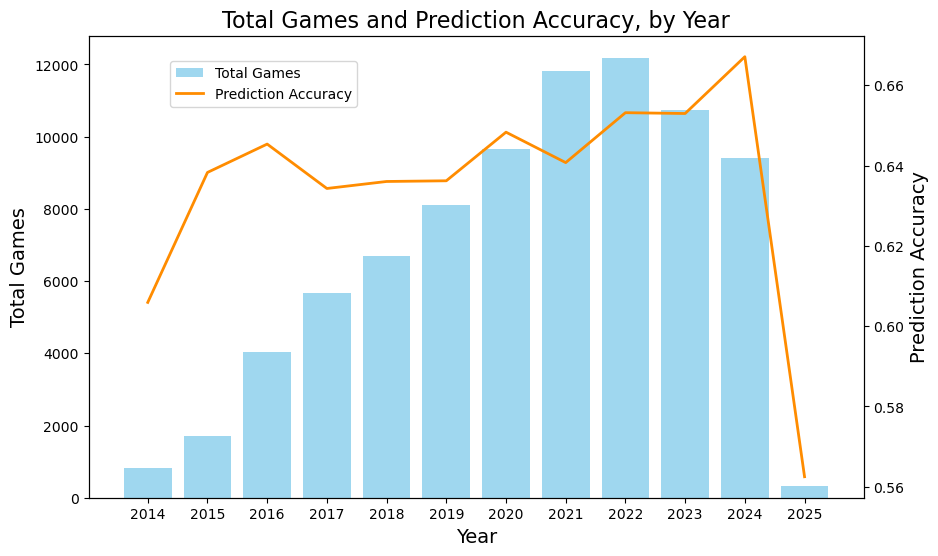

In [136]:
games_each_year = elo_record_df.groupby("year").size()

fig, ax1 = plt.subplots(figsize=(10,6))

ax1.bar(games_each_year.index,
        games_each_year.values,
        label="Total Games",
        color="skyblue",
        alpha=0.8)

plt.xticks(range(2014,2026,1))
ax1.set_xlabel("Year", fontsize=14)
ax1.set_ylabel("Total Games", fontsize=14)

ax2 = ax1.twinx()
ax2.plot(elo_record_df.groupby("year")["predict"].mean(),
         label="Prediction Accuracy",
         color="darkorange",
         linewidth=2)

ax2.set_ylabel("Prediction Accuracy", fontsize=14)

plt.title("Total Games and Prediction Accuracy, by Year", fontsize=16)
fig.legend(loc='lower center', bbox_to_anchor=(0.3, 0.75), ncol=1)

plt.show()

2014, the first year, with the least data to train on, has the lowest prediction accuracy.

We can see a general trend for the prediction accuracy being higher in 2020 to 2024 than in the 4 years previously.

This somewhat correlates to the number of games played per year.  Although, I suspect that this will be influenced also by the number of new teams playing each year.

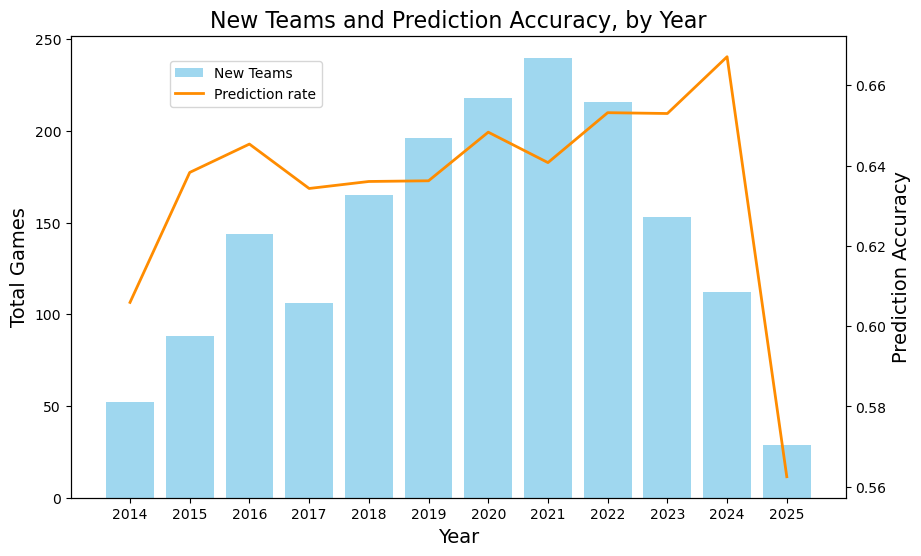

In [139]:
new_teams_each_year = (elo_record_df.loc[elo_record_df["team_win_playerid"].drop_duplicates().index,"year"]
                       .value_counts()
                       .sort_index())

fig, ax1 = plt.subplots(figsize=(10,6))
ax1.bar(new_teams_each_year.index,
        new_teams_each_year.values,
        label="New Teams",
        color="skyblue",
        alpha=0.8)

plt.xticks(range(2014,2026,1))
ax1.set_xlabel("Year", fontsize=14)
ax1.set_ylabel("Total Games", fontsize=14)

ax2 = ax1.twinx()
ax2.plot(elo_record_df.groupby("year")["predict"].mean(),
         label="Prediction Accuracy",
         color="darkorange",
         linewidth=2)

ax2.set_ylabel("Prediction Accuracy", fontsize=14)

plt.title("New Teams and Prediction Accuracy, by Year", fontsize=16)
fig.legend(loc='lower center', bbox_to_anchor=(0.3, 0.75), ncol=1)

plt.show()

We can see that 2024 and 2023 had fewer new teams than the years preceding them.

We can also see that the number of new teams per year increases less steeply than the number of games per year.

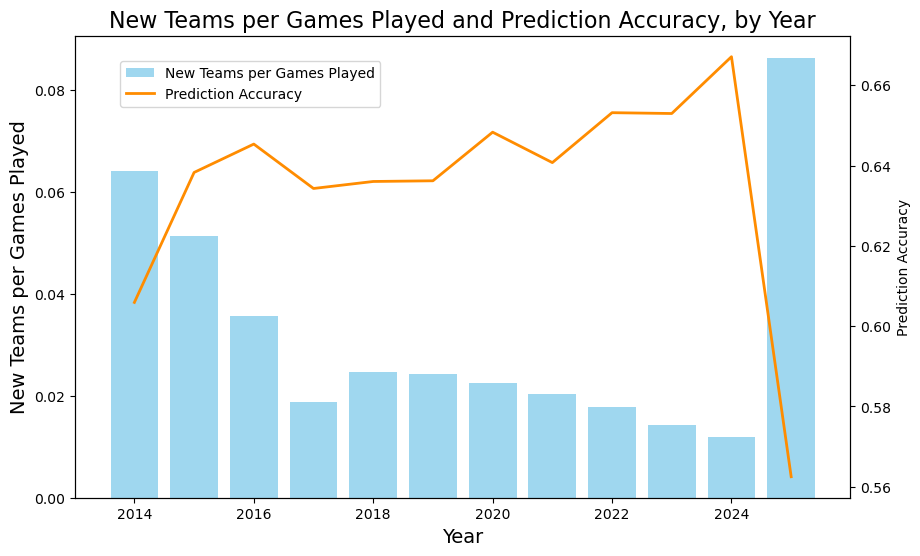

In [142]:
new_teams_per_games_played = new_teams_each_year / games_each_year

fig, ax1 = plt.subplots(figsize=(10,6))
ax1.bar(new_teams_per_games_played.index,
        new_teams_per_games_played.values,
        label="New Teams per Games Played",
        color="skyblue",
        alpha=0.8)

ax1.set_ylabel("New Teams per Games Played", fontsize=14)
ax1.set_xlabel("Year", fontsize=14)

ax2 = ax1.twinx()
ax2.plot(elo_record_df.groupby("year")["predict"].mean(),
         label="Prediction Accuracy",
         color="darkorange",
         linewidth = 2)

ax2.set_ylabel("Prediction Accuracy")

plt.title("New Teams per Games Played and Prediction Accuracy, by Year", fontsize=16)
fig.legend(loc='lower center', bbox_to_anchor=(0.3, 0.75), ncol=1)

plt.show()

When we look at thebar chart of New Teams per Games Played, it appears to better explain the variations in Prediction Accuracy.

It makes sense that the less games the elo system has to adjust to new teams, the worse it will be at predicting their results.

In [146]:
print(f"We can confirm this by looking at the r value of new teams per games played and the prediction accuracy: {pd.DataFrame({'new_teams_per_games_played':new_teams_per_games_played, 'prediction_accuracy':elo_record_df.groupby('year')['predict'].mean()}).corr().iloc[0,1]}")

We can confirm this by looking at the r value of new teams per games played and the prediction accuracy: -0.9024332834191106


An r value of -0.90 shows very strong negative correlation.

I will also look at the differences between the different leagues through the elo system.

In [149]:
# Reading in the dflol file.
dflol = pd.read_pickle("dflol.pkl")

# Merging the 2 dataframes together.
elo_with_league = elo_record_df.merge(dflol.loc[dflol["participantid"] == 100, "league"], on="gameid")

# Finding the mean elo per game for each league.
mean_elo_by_league = elo_with_league.groupby(["league", "year"])[["win_total_elo", "lose_total_elo"]].mean()

In [180]:
((mean_elo_by_league["win_total_elo"] + mean_elo_by_league["lose_total_elo"])
 .rename("mean elo per game")
 .sort_values(ascending=False)
 .head(20))

league  year
MSI     2024    80527.002481
EWC     2024    80526.378168
WLDs    2024    80395.886919
MSI     2023    80393.534237
        2022    80304.213279
WLDs    2023    80290.936997
MSI     2021    80244.894421
WLDs    2022    80216.225054
        2021    80208.067528
        2020    80169.217660
AC      2024    80156.677587
MSC     2020    80153.883990
WLDs    2019    80123.578731
MSI     2019    80107.841805
LCK     2024    80091.736228
MSI     2018    80091.672991
LEC     2024    80084.508223
WLDs    2018    80056.024470
LCS     2024    80032.897857
EM      2023    80029.728924
dtype: float64

The leagues with the highest mean elo are international tournaments where only the best teams from each region qualify (AC, EWC, MSI, & WLDs).

The competitions with the highest ratings are all in 2024, and so the elo system, despite having 11 years worth of data has not yet settled plateaued and the highest ratings are still rising.

It is well known that the 2 highest quality domestic leagues are the LCK and LPL, but yet the domestic leagues of LCK, lEC, and LCS are all present in the top 20, whilst the LPL isn't.

The LCS and LEC may have earlier elimination of its weaker teams and so have its high elo teams play a higher proportion of matches than the high elo LPL teams do in the LPL.

Because the mean elo rating I calculated is based off of the mean elo rating in each game this would cause the mean elo ratings of the LCS and LEC to be skewed higher.

This is also probably caused by the elo system being poor at adjusting the ratings between individual leagues.

Because the default elo ratings for each league are the same, despite some leagues being much higher in quality than others, a player may gain a very high elo rating in a lower league, and whilst this rating will be accurate for their league, if they move to a better league, the elo system will overestimate how good they are.

Ideally, there should be a record of each team's (and player's) home league and so there can be a league rating to properly adjust teams and players who move between leagues.  However, the available data does not include this information and therefore, these problems persist in my elo system.

We can see this in that the international tournaments, that include teams from a variety of leagues, (AC, EWC & WLDs) are all in the bottom 10 leagues for prediction accuracy

In [181]:
elo_with_league.groupby(["league"])["predict"].mean().rename("Prediction Accuracy").sort_values().head(10)

league
NERD    0.452381
EWC     0.473684
AC      0.514286
MSC     0.520000
NASG    0.525641
Riot    0.550000
OCS     0.573446
HC      0.578431
NEST    0.580000
WLDs    0.587149
Name: Prediction Accuracy, dtype: float64

# Conclusions
The main findings of this notebook include, but are not limited by:

The confirmation that the feasibility of the of creating an elo system to predict LoL games is possible.

That the elo system predicts games better when it has already been trained and developed ratings for the teams that are playing.

The players who play the game are a more important feature to predict the result than the champions the players pick.

However, the speed at which the relative strength of champions changes is faster than that of players.

The most important position for predicting the result of a game is Mid.  The least important is Top.

The organisation/team that players play for is an important feature when predicting the result of games.

The elo system struggles when there are international tournaments because it combines several separate ecosystems without adjusting for the variation in strength of the leagues.

### Implications:
These results could be used by professional League of Legends teams to priorities the positions that most affect the result of games.  They could also be used by teams to find an approximation for the strength of opponents they face.

### Further Work:
 Further analysis could be done on which teams and players the elo system has the highest prediction accuracy for.

The elo system could also take further parameters, such as the gold differential or the game length, to determine the margin of victory, and these could be used to adjust the change of ratings.

I will use the calculated elo ratings as a feature in my next notebook LoL_Predictions.

Further work could also be done to make an elo system that automatically updates by downloading recent game data and calculating the elo ratings for it to have an always up-to-date database of player, team, and champion ratings.